# **Integrating Experimental Feedback into DCA Generative Models**

In this notebook, we train an **experiment-informed DCA model** on **Chorismate Mutase** protein enzymes.

We start by importing the main PyTorch-based DCA package, **`adabmDCA`**, along with other essential utilities.

In [34]:
from pathlib import Path
import numpy as np
import torch

%pip install viennarna
%pip install adabmDCA

# Import some useful functions from reintegration.py
from reintegration import get_effective_frequencies,get_predictions,plot_prediction_histogram

# Import some useful functions from adabmDCA
from adabmDCA.fasta import get_tokens, import_from_fasta
from adabmDCA.training import train_graph
from adabmDCA.functional import one_hot
from adabmDCA.utils import init_parameters, init_chains, get_device, get_dtype, get_mask_save
from adabmDCA.sampling import get_sampler
from adabmDCA.io import load_params,save_params, save_chains

In [10]:
# Set the GPU device
device = get_device("cuda")
dtype = get_dtype("float32")

Running on Tesla T4


## Importing the Data

Here, we load the necessary data files for our analysis:

- **`reintegration.py`**: A Python module that enables us to use the standard **adabmDCA** package to train a reintegrated DCA model.
- **`Natural_CM.faa`**: A multiple sequence alignment (MSA) of natural **Chorismate Mutase** enzymes.
- **`P1_sample_CM.faa`**: A multiple sequence alignment of **DCA-generated artificial Chorismate Mutase** enzymes.
- **`P1_sample_exp.txt`**: Experimental results for the **P1_sample** set, indicating enzymatic functionality:
  - `+1` → The sequence is **functional**.
  - `-1` → The sequence is **non-functional**.

The dataset and experimental data are sourced from [**Russ et al.**](https://www.science.org/doi/10.1126/science.aba3304)

In [31]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

!wget "https://github.com/FrancescoCalvanese/DCA_Reintegration/raw/main/Notebook_Implementation/Notebook_DATA.zip"
!unzip "/content/Notebook_DATA.zip" -d /content/

--2025-02-12 16:55:09--  https://github.com/FrancescoCalvanese/DCA_Reintegration/raw/main/Notebook_Implementation/Notebook_DATA.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/FrancescoCalvanese/DCA_Reintegration/main/Notebook_Implementation/Notebook_DATA.zip [following]
--2025-02-12 16:55:09--  https://raw.githubusercontent.com/FrancescoCalvanese/DCA_Reintegration/main/Notebook_Implementation/Notebook_DATA.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93649 (91K) [application/zip]
Saving to: ‘Notebook_DATA.zip’

Notebook_DATA.zip   100%[===================>]  91.45K  --.-KB/s    in 0.

We set our model alphabet to **proteins** and load the natural dataset:

In [32]:
# Select the alphabet corresponding to protein sequences
tokens = get_tokens("protein")

# Import the Natural MSA
path_data = "/content/Natural_CM.faa"
headers, sequences = import_from_fasta(path_data, tokens=tokens, filter_sequences=True)
M, L, q = len(sequences), len(sequences[0]), len(tokens)

print(f"Number of sequences in the MSA: M={M}")
print(f"Length of the MSA: L={L}")
print(f"Number of Potts states: q={q}")

msa_enc = torch.tensor(sequences, device=device, dtype=torch.int32)

Number of sequences in the MSA: M=1130
Length of the MSA: L=96
Number of Potts states: q=21


We load the dataset of **DCA-tested designs** from [**Russ et al.**](https://www.science.org/doi/10.1126/science.aba3304), along with the corresponding experimental results.  

This dataset serves as our **reintegration dataset**, allowing the DCA model to incorporate experimental feedback.

In [33]:
# Import the reintegration dataset
path_data_reint = "/content/P1_sample_CM.faa"
headers_r, sequences_r = import_from_fasta(path_data_reint, tokens=tokens, filter_sequences=True)
M_r, L_r, q_r = len(sequences_r), len(sequences_r[0]), len(tokens)

print(f"Number of sequences to be reintegrated: M_r={M_r}")

msa_enc_r = torch.tensor(sequences_r, device=device, dtype=torch.int32)

Number of sequences to be reintegrated: M_r=1003


In [13]:
# Import the adjustment vector
adjustment_vector = []
with open("/content/P1_sample_exp.txt", "r") as f:
    adjustment_vector = [float(line.strip()) for line in f]
adjustment_tensor = torch.tensor(adjustment_vector)

We set the **reintegration strength parameter**  **λ**  **to** **1**.  

The **adjustment vector ω** is assigned **+1** for **functional sequences** and **-1** for **non-functional sequences**. This ensures that both the **natural training dataset** and the **reintegration dataset** contribute **equally** to the model.  

This reintegration scheme (+1 for functional sequences, -1 for non-functional sequencs and λ=1) is a solid starting point for applying the reintegration procedure.

In [14]:
# Set the reintegration strength
lambda_ = 1

We compute the **effective sequences** that will be used as training targets for the DCA model, as described in [paper link].

In [15]:
# Get the effective frequencies
fi_eff,fij_eff = get_effective_frequencies(msa_enc=msa_enc,msa_enc_r=msa_enc_r,adjustment_tensor=adjustment_tensor,lambda_=lambda_)

In [16]:
output_folder_reint = f"model_CM_reint_lambda{lambda_}"
folder_reint = Path(output_folder_reint)
folder_reint.mkdir(parents=True, exist_ok=True)

# Label for the ouput files
label_reint = "bmDCA_reint"

# Paths for the output files
path_params_reint  = folder_reint / Path(f"{label_reint}_params.dat")
path_chains_reint  = folder_reint / Path(f"{label_reint}_chains.fasta")

We set the DCA training parameters:

In [17]:
# Choose the hyperparameters of the training
nchains = 10000 # Number of Monte Carlo chains
nsweeps = 10    # Number of sweeps at each gradient update
target = 0.95   # Target Pearson Cij
lr = 0.05       # Learning rate

params_reint = init_parameters(fi=fi_eff)
chains_reint = init_chains(num_chains=nchains, L=L,q=q, device=device, fi=fi_eff).cuda()
log_weights_reint = torch.zeros(len(chains_reint), device=device)


# Mask for removing the autocorrelations
mask_reint = torch.ones(size=(L, q, L, q), dtype=torch.bool, device=device)
mask_reint[torch.arange(L), :, torch.arange(L), :] = 0

# Mask for saving only the upper diagnal part of the weight_matrix
mask_save_reint = get_mask_save(L=L, q=q, device=device)

# Select the sampler
sampler = get_sampler("gibbs")

In [18]:
chains_reint, params_reint, log_weights_reint = train_graph(
    sampler=sampler,
    chains=chains_reint,
    fi=fi_eff,
    fij=fij_eff,
    params=params_reint,
    mask=mask_reint,
    nsweeps=nsweeps,
    lr=lr,
    max_epochs=10000,
    target_pearson=target,
)

We save the trained model and perform **functionality prediction classification** on the generated sequences using the **logistic regression classifier** described in [Russ et al.](https://www.science.org/doi/10.1126/science.aba3304).

In [19]:
# Save parameters and chains
save_params(fname=path_params_reint, params=params_reint, mask=mask_save_reint, tokens=tokens)
save_chains(fname=path_chains_reint, chains=chains_reint.argmax(-1), tokens=tokens, log_weights=log_weights_reint)

In [21]:
predictions = get_predictions("/content/Natural_CM.faa",f"model_CM_reint_lambda{lambda_}/bmDCA_reint_chains.fasta")

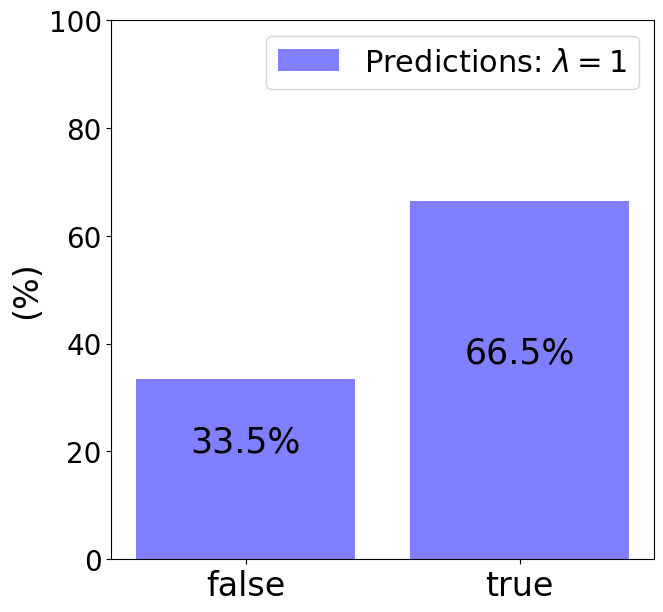

In [22]:
plot_prediction_histogram(predictions,lambda_)

The **reintegrated model** produces **67% predicted-functional designs**, compared to **34%** for the non-reintegrated model.